In [1]:
#Importing libraries
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import random
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from scipy.integrate import odeint

#Numerical neurons parameters for the project
V_REST = 15 * b2.mV
V_RESET = -50 * b2.mV
MEMBRANE_RESISTANCE = 50 * b2.ohm
MEMBRANE_TIME_SCALE = 10 * b2.ms
FIRING_THRESHOLD = 0 * b2.mV
BETA = 100000 * b2.Hz #mHz do not exist, code it for 100 mHz instead ?

## EX 0

In [3]:
def Iext(t, I0 = 0.5 * b2.mamp, w = 100*b2.Hz, unit_time=b2.ms):
    return I0*(1+np.sin(w*t*unit_time))

def escape_function(voltage) :
                if voltage > FIRING_THRESHOLD :
                    return BETA
                else :
                    return 0
                
def non_interacting(vi, T=100*b2.ms,unit_time=b2.ms):
    steps = int(T/unit_time)+1    
    spike_train = np.zeros((steps, len(vi))).astype(bool)
    voltages = np.zeros((steps, len(vi)))
    voltages[0] = vi*b2.ms
    # Set the initial condition and time points
    times = np.arange(1, steps, 1)
    dt = 1*unit_time
    for i in range(0,steps-1):
        voltages[i+1] = voltages[i]*b2.mV+dt*(-(voltages[i]*b2.mV-V_REST)+MEMBRANE_RESISTANCE*Iext(times[i],unit_time=unit_time))/MEMBRANE_TIME_SCALE
        # TO DO: check the actual probability, BETA*(v*b2.mV>FIRING_THRESHOLD)*1*b2.ms takes values larger than 1, it's not a probability
        firing = np.random.binomial(1,BETA*(voltages[i]*b2.mV>FIRING_THRESHOLD)*0.1*b2.ms*dt>0)
        #firing = escape_function(voltages[i]*b2.mV)*dt
        voltages[i+1]+=(V_RESET-voltages[i]*b2.mV)*firing
        spike_train[i]=firing

    return voltages, spike_train

In [4]:
N = 100
Vi = np.random.uniform(V_RESET,FIRING_THRESHOLD,100)
Vs, ST = non_interacting(Vi, unit_time=1*b2.ms)

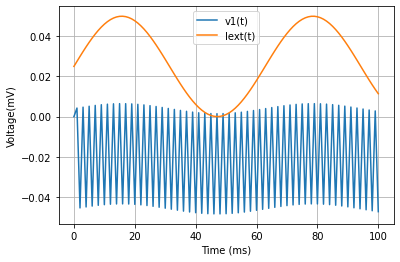

In [5]:
steps = Vs.shape[0]
t = np.arange(0, steps, 1)
Ie = Iext(t)*MEMBRANE_RESISTANCE

plt.plot(t, Vs[:, 0], label='v1(t)')
plt.plot(t, Ie, label='Iext(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage(mV)')
plt.grid()
plt.legend()
plt.show()

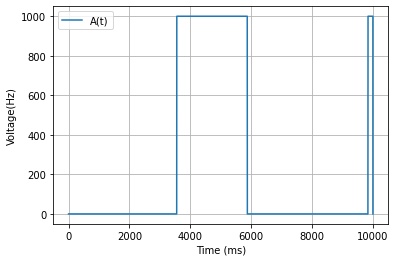

In [6]:
At = [np.sum(s)/N for s in ST]
plt.plot(t, At/b2.ms, label='A(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage(Hz)')
plt.grid()
plt.legend()
plt.show()